In [44]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import os
from pdf2image import convert_from_path
import tempfile

In [45]:
%matplotlib inline
def sw(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [46]:
image_path = '..\\..\\data\\dev\\1n.jpg'
# image_path = '..\\..\\data\\dev\\23.jpg'

In [47]:
im = cv2.imread(image_path, 0)
ret,th = cv2.threshold(im, 225, 255, cv2.THRESH_BINARY_INV)

kernel = np.ones((5,5), np.uint8)
th2 = cv2.dilate(th, kernel)

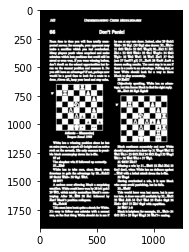

In [48]:
sw(th2)

In [49]:
contours, hierarchy = cv2.findContours(th2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours, hierarchy = cv2.findContours(th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
contours.sort(key=lambda cnt: cv2.contourArea(cnt), reverse=True)
filtered_contours = []
filtered_rects = []
buf = 0
min_area = 64*25*25
for i, cnt in enumerate(contours):
  area = cv2.contourArea(cnt)
  if not (min_area <= area):
    # print('area', area)
    continue
  epsilon = 0.01*cv2.arcLength(cnt,True)
  approx = cv2.approxPolyDP(cnt,epsilon,True)
  num_sides = len(approx)
  # check for square
  if not (4 == num_sides):
    # print('sides', num_sides)
    continue
  x, y, w, h = cv2.boundingRect(cnt)
  h_max, w_max = im.shape
  if abs(w - h) > 25:
    # print('x,y,w,h', x, y, w, h)
    continue
  
  rect = (max(y - buf, 0), min(y + h + buf, h_max), max(x - buf, 0), min(x + w + buf, w_max))
  filtered_contours.append(cnt)
  filtered_rects.append(rect)


In [50]:
len(filtered_contours)

2

In [51]:
rect = filtered_rects[1]
potential_board = im[rect[0]:rect[1], rect[2]:rect[3]] 
pb_th2 = th2[rect[0]:rect[1], rect[2]:rect[3]] 

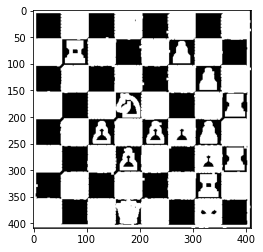

In [52]:
# sw(potential_board)
sw(pb_th2)

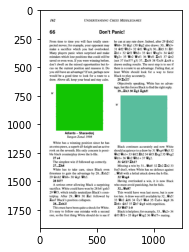

In [53]:
con = cv2.imread(image_path, 1)
for c in filtered_contours:
  color = list(np.random.random(size=3) * 256)
  cv2.drawContours(con, [c], -1, color, -1);
sw(con)

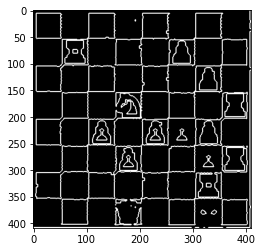

In [78]:
lap = cv2.Laplacian(pb_th2, cv2.CV_64F)
lap = np.uint8(np.absolute(lap))
kernel = np.ones((5,5), np.uint8)
lap2 = cv2.dilate(lap, kernel)
sw(lap)

dim,thres,min_line_length,max_line_gap 51.125 46 23 9


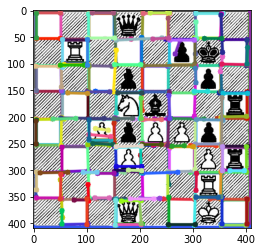

In [79]:
cdstP = cv2.cvtColor(potential_board, cv2.COLOR_GRAY2RGB)
dim = min(w, h) / 8
thres = int(0.9*dim)
min_line_length = max(thres // 2, 20)
max_line_gap = max(thres // 5, 5)

print('dim,thres,min_line_length,max_line_gap',dim,thres,min_line_length,max_line_gap)

linesP = cv2.HoughLinesP(lap, rho=1, theta=np.pi / 180, threshold=thres, lines=None, 
                         minLineLength=min_line_length, maxLineGap=max_line_gap)
hls = []
vls = []
if linesP is not None:
    for i in range(0, len(linesP)):
      l = linesP[i][0]
      is_hor = abs(l[0] - l[2]) < 10
      is_vert = abs(l[1] - l[3]) < 10
      if is_hor or is_vert:
        if is_hor:
          color = (0, 0, 255)
          hls.append(l)
        else:
          color = (0, 255, 0)
          vls.append(l)
        
        color = list(np.random.random(size=3) * 256)
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), color, 3, cv2.LINE_AA)
        cv2.circle(cdstP, (l[0], l[1]), 5, color, -1)
        cv2.circle(cdstP, (l[2], l[3]), 5, color, -1)
sw(cdstP)
# cv2.imwrite('../data/dev/edge th2 laplacian houghlineP 23.png', cdstP)

In [80]:
len(hls), len(vls)

(95, 127)

In [81]:
def find_intersection(line1, line2):
    # extract points
    x1, y1, x2, y2 = line1[0], line1[1], line1[2], line1[3]
    x3, y3, x4, y4 = line2[0], line2[1], line2[2], line2[3]
    # compute determinant
    det = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
    # parallel or same line
    if det == 0: 
      return np.inf, np.inf
    Px = ((x1*y2 - y1*x2)*(x3-x4) - (x1-x2)*(x3*y4 - y3*x4))/ det
    Py = ((x1*y2 - y1*x2)*(y3-y4) - (y1-y2)*(x3*y4 - y3*x4))/ det
    return Px, Py

Wall time: 599 ms


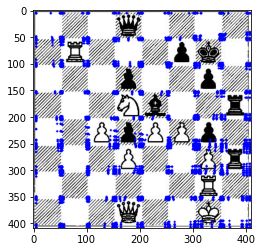

In [82]:
%%time
cdstP = cv2.cvtColor(potential_board, cv2.COLOR_GRAY2RGB)
lh, lw = lap2.shape
pts = []
for hl in hls:
  for vl in vls:
    ix, iy = find_intersection(hl, vl)
    if 0 <= ix <= lh and 0 <= iy <= lw:
      pt = (int(ix), int(iy))
      pts.append(pt)

for pt in pts:
  cv2.circle(cdstP, pt, 2, (255, 0, 0), -1)
sw(cdstP)
# cv2.imwrite('../data/dev/edge th2 laplacian houghlineP intersect.png', cdstP)

In [83]:
nclusters = 81
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
_, _, centers = cv2.kmeans(np.float32(pts), nclusters, None, criteria, 10, cv2.KMEANS_PP_CENTERS)


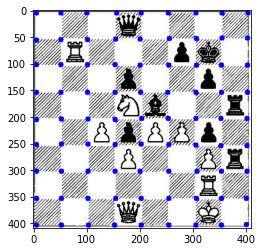

In [84]:
cdstP = cv2.cvtColor(potential_board, cv2.COLOR_GRAY2RGB)
for cx, cy in centers:
    cx = np.round(cx).astype(int)
    cy = np.round(cy).astype(int)
    cv2.circle(cdstP, (cx, cy), 5, (255, 0, 0), -1)
sw(cdstP)
# cv2.imwrite('../data/dev/edge th2 laplacian houghlineP intersect kmeans 23.png', cdstP)

In [85]:
def closest_multiple(x, n):
  low = int(x / n)
  cm = low * n if x - low * n < (low + 1) * n - x else (low + 1) * n
  diff = abs(x - cm)
  return cm, diff

clist = centers.tolist()
clist.sort()
close_thres = 25
# check kmeans corners with the expected corners of the grid
# a point that is sufficiently close to an expected corner that is far away from
# other points in the list is counted
matching_points = 0
for i, c in enumerate(clist):
  # look at previous to see if its the same point
  if i != 0:
    prev = clist[i-1]
    if abs(c[0] - prev[0]) < close_thres and abs(c[1] - prev[1]) < close_thres:
      continue
  c0cm, c0diff = closest_multiple(c[0], dim)
  c1cm, c1diff = closest_multiple(c[1], dim)
  # too far from expected corner
  if c0diff > close_thres or c1diff > close_thres:
    continue
#   print('c, cm, diff', c, (c0cm, c1cm), (c0diff, c1diff))
  matching_points += 1
print(matching_points)

81


In [62]:
w/8, h/8

(51.25, 51.125)

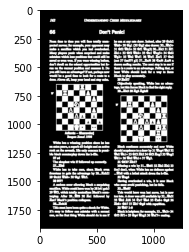

In [63]:
ret,th = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

kernel = np.ones((5,5), np.uint8)
th2 = cv2.dilate(th, kernel)
sw(th2)

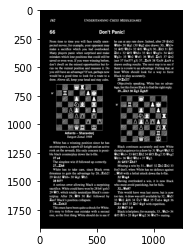

In [64]:
ret,th = cv2.threshold(im, 225, 255, cv2.THRESH_BINARY_INV)
sw(th)